<a href="https://colab.research.google.com/github/nicholashagemann/lambdalectures/blob/main/DS29_GS_Unit2_Sprint2_Module4_Nivi.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Lambda School Data Science

*Unit 2, Sprint 2, Module 4*

---

# Overview
1. Announcements
2. Warmup
3. A few pointers for yesterday's module
4. Saving models
5. Classification metrics
6. Working locally vs cloud

# Classification Metrics

- get and interpret the **confusion matrix** for classification models
- use classification metrics: **precision, recall**
- understand the relationships between precision, recall, **thresholds, and predicted probabilities**, to help **make decisions and allocate budgets**

In [ ]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Kaggle-Challenge/master/data/'
    !pip install category_encoders==2.*

# If you're working locally:
else:
    DATA_PATH = '../data/'

In [ ]:
from category_encoders import OneHotEncoder, OrdinalEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.metrics import plot_confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
#Class 0 -  1000 samples - no attacks in your network
#Class 1 - 100 samples - network attacks
100/1100
#ASsume all 100 samples were misclassified as Class 0
1000/1100

0.9090909090909091

# I. Wrangle Data

In [ ]:
train = pd.merge(
    pd.read_csv('train_features.csv', na_values=[0, -2.000000e-08], parse_dates=['date_recorded']), 
    pd.read_csv('train_labels.csv', na_values=[0, -2.000000e-08])
    )

def wrangle(df):

  # Set the index to 'id'
  df.set_index('id', inplace=True)

  # Drop Constant Column
  df.drop(columns='recorded_by', inplace=True)

  # Drop Duplicate Column
  df.drop(columns='quantity_group', inplace=True)

  # Create age feature
  df['pump_age'] = df['date_recorded'].dt.year - df['construction_year']
  df.drop(columns='date_recorded', inplace=True)

  # Drop High Cardinality Columns
  cols_to_drop = [col for col in df.select_dtypes('object') if df[col].nunique() > 100]
  df.drop(columns=cols_to_drop, inplace=True)

  # Drop columns with high proportion of null values
  df.drop(columns='num_private', inplace=True)

  return df

train = wrangle(train)

X_test=pd.read_csv('test_features.csv',na_values=[0, -2.000000e-08], parse_dates=['date_recorded'])
test=wrangle(X_test)

In [ ]:
train.head()

,amount_tsh,gps_height,longitude,latitude,basin,region,region_code,district_code,population,public_meeting,scheme_management,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group,pump_age
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
454.0,50.0,2092.0,35.426020,-4.227446,Internal,Manyara,21,1.0,160.0,True,Water Board,True,1998.0,gravity,gravity,gravity,water board,user-group,pay per bucket,per bucket,soft,good,insufficient,spring,spring,groundwater,communal standpipe,communal standpipe,functional,15.0
510.0,NaN,NaN,35.510074,-5.724555,Internal,Dodoma,1,6.0,NaN,True,VWC,True,NaN,india mark ii,india mark ii,handpump,vwc,user-group,never pay,never pay,soft,good,enough,shallow well,shallow well,groundwater,hand pump,hand pump,functional,NaN
14146.0,NaN,NaN,32.499866,-9.081222,Lake Rukwa,Mbeya,12,6.0,NaN,True,VWC,False,NaN,other,other,other,vwc,user-group,never pay,never pay,soft,good,enough,shallow well,shallow well,groundwater,other,other,non functional,NaN
47410.0,NaN,NaN,34.060484,-8.830208,Rufiji,Mbeya,12,7.0,NaN,True,VWC,True,NaN,gravity,gravity,gravity,vwc,user-group,pay monthly,monthly,soft,good,insufficient,river,river/lake,surface,communal standpipe,communal standpipe,non functional,NaN
1288.0,300.0,1023.0,37.032690,-6.040787,Wami / Ruvu,Morogoro,5,1.0,120.0,True,VWC,True,1997.0,other,other,other,vwc,user-group,pay when scheme fails,on failure,salty,salty,enough,shallow well,shallow well,groundwater,other,other,non functional,14.0


In [ ]:
pd.unique(train['status_group'])

array(['functional', 'non functional', 'functional needs repair'],
      dtype=object)

## EDA

- How can we transform our target so that this is a **binary classification** problem?

In [ ]:
# Classify into pumps that need repair and pumps that do not need repairs.
#functional - 0
#non functional and functional needs repair - 1

In [ ]:
train.loc[train['status_group'] == 'functional','needs_repair'] = 0
train.loc[train['status_group'] != 'functional','needs_repair'] = 1

In [ ]:
train['needs_repair']=(train['status_group'] != 'functional').astype(int)

In [ ]:
train.head()

,amount_tsh,gps_height,longitude,latitude,basin,region,region_code,district_code,population,public_meeting,scheme_management,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group,pump_age,needs_repair
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
454.0,50.0,2092.0,35.426020,-4.227446,Internal,Manyara,21,1.0,160.0,True,Water Board,True,1998.0,gravity,gravity,gravity,water board,user-group,pay per bucket,per bucket,soft,good,insufficient,spring,spring,groundwater,communal standpipe,communal standpipe,functional,15.0,0
510.0,NaN,NaN,35.510074,-5.724555,Internal,Dodoma,1,6.0,NaN,True,VWC,True,NaN,india mark ii,india mark ii,handpump,vwc,user-group,never pay,never pay,soft,good,enough,shallow well,shallow well,groundwater,hand pump,hand pump,functional,NaN,0
14146.0,NaN,NaN,32.499866,-9.081222,Lake Rukwa,Mbeya,12,6.0,NaN,True,VWC,False,NaN,other,other,other,vwc,user-group,never pay,never pay,soft,good,enough,shallow well,shallow well,groundwater,other,other,non functional,NaN,1
47410.0,NaN,NaN,34.060484,-8.830208,Rufiji,Mbeya,12,7.0,NaN,True,VWC,True,NaN,gravity,gravity,gravity,vwc,user-group,pay monthly,monthly,soft,good,insufficient,river,river/lake,surface,communal standpipe,communal standpipe,non functional,NaN,1
1288.0,300.0,1023.0,37.032690,-6.040787,Wami / Ruvu,Morogoro,5,1.0,120.0,True,VWC,True,1997.0,other,other,other,vwc,user-group,pay when scheme fails,on failure,salty,salty,enough,shallow well,shallow well,groundwater,other,other,non functional,14.0,1


# II. Split Data

In [ ]:
target='needs_repair'
X = train.drop(columns=target)
y = train[target]

In [ ]:
X.drop(columns = ['status_group'],inplace=True)

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)


# Baseline

In [ ]:
print('Baseline Accuracy:', y_train.value_counts(normalize=True).max())

Baseline Accuracy: 0.551217548802576


# Build Model

- `OrdinalEncoder`
- `SimpleImputer`
- `RandomForestClassifier`

In [ ]:
model = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(),
    RandomForestClassifier(n_estimators=25,
                           n_jobs=-1,
                           random_state=42)
)

model.fit(X_train, y_train);

# Interlude: Beware or Leakage

 

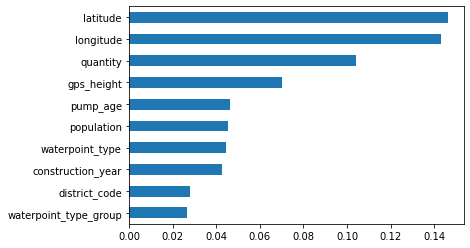

In [ ]:
importances = model.named_steps['randomforestclassifier'].feature_importances_
features = X_train.columns
pd.Series(importances, index=features).sort_values().tail(10).plot(kind='barh');

# Check Metrics

**Accuracy Score**

In [ ]:
print('Training Accuracy:', model.score(X_train, y_train))
print('Validation Accuracy:', model.score(X_val, y_val))

Training Accuracy: 0.993660563973064
Validation Accuracy: 0.8176557239057239


**Confusion Matrix**

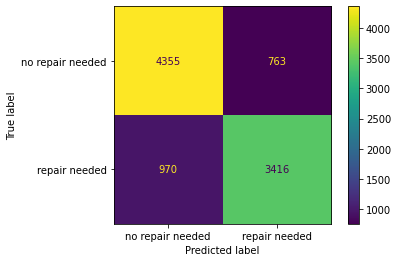

In [ ]:
plot_confusion_matrix(model, X_val,y_val, values_format = '.0f',display_labels=['no repair needed','repair needed'])

**Precision Score**

Of all the pumps that you predicted as needing repair, what proportion actually needed repair?

In [ ]:
#precision = (tp/tp+fp)
3416/(3416+763)

0.8174204355108877

**Recall Score** 

Of those pumps that actually needed repair, what proportion did you correctly predict as needing repair?

In [ ]:
# recall = (tp/tp+fn)
3416/(3416+970)

0.7788417692658459

**Classification Report**

In [ ]:
print(classification_report(y_val,model.predict(X_val),target_names = ['no repair needed','repair needed']))

                  precision    recall  f1-score   support

no repair needed       0.82      0.85      0.83      5118
   repair needed       0.82      0.78      0.80      4386

        accuracy                           0.82      9504
       macro avg       0.82      0.81      0.82      9504
    weighted avg       0.82      0.82      0.82      9504



In [ ]:
classification_report

TypeError: ignored

In [ ]:
#f1 score = (2*precision*recall)/(precision+recall)

# Case Study

Let's say that is costs the Tanzanian government $100 to inspect a water pump, and there is only funding for 2000 pump inspections. 

In [ ]:
n_inspections = 2000
repair_prob = y_val.value_counts(normalize=True).min()
print('The number of inpsections conducted is', n_inspections)

The number of inpsections conducted is 2000


Scenario 1: Choose pumps randomly

In [ ]:
# if you randomly chose pumps, the number of pumps 
#you would correctly identify as needing repair = (n_observations)*repair_prob
print('The number of inpsections conducted is', n_inspections)
pumps_repaired = n_inspections * repair_prob
print('The number of pumps that we would identify as needing repair without a model is ',pumps_repaired)

The number of inpsections conducted is 2000
The number of pumps that we would identify as needing repair without a model  922.979797979798


Scenario 2: Using our model "out of the box"

In [ ]:
from sklearn.metrics import precision_score

In [ ]:
model_precision = precision_score(y_val,model.predict(X_val))
print('The number of pumps that our model would identify as needing repair is ', model_precision*n_inspections)

The number of pumps that our model would identify as needing repair is  1634.8408710217755


Scenario 3: We empasize **precision** in our model, and only select pumps that our model is very certain (`>0.85`) need repair.

In [ ]:
data = {'y_val': y_val,
        'y_pred_prob': model.predict_proba(X_val)[:,-1]}
result = pd.DataFrame(data)

In [ ]:
result

,y_val,y_pred_prob
id,,
20217.0,0,0.0
67143.0,0,0.0
2948.0,0,0.0
40301.0,0,0.0
61519.0,0,0.0
...,...,...
36741.0,0,0.0
22793.0,0,0.0
6038.0,0,0.0


In [ ]:
result.loc[result['y_pred_prob'] > 0.85,'y_pred_prob'] = 1
result.loc[result['y_pred_prob'] <= 0.85,'y_pred_prob'] = 0

In [ ]:
model_precision = precision_score(result['y_val'],result['y_pred_prob'])
print('The number of pumps that our model would identify as needing repair is ', model_precision*n_inspections)

The number of pumps that our model would identify as needing repair is  1908.5667215815486


# You can see how the 'out of box' model does better than a random guess and the model gets better as your tweak the threshold. Out of 2000 inspections, our models help in identifying the faulty pumps better.